<a href="https://colab.research.google.com/github/tincho-mehaudy/DMCyT/blob/master/TP1-7.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 7.3 - Análisis espectral de un *track*

## Cargamos las librerías
Nos dejamos solo los *chunks* imprescindibles del *notebook* original  ["Introducción al análisis automático de sonido[...]"](http://datamining.dc.uba.ar/campus/mod/url/view.php?id=1591)

In [1]:
!pip -q install spotipy
!pip -q install -U librosa seaborn
!wget -q https://www.dropbox.com/s/nqjs076fidighaz/SopSax.NoVib.mf.C4B4.wav?dl=1 -O SopSax.NoVib.mf.C4B4.wav

     |████████████████████████████████| 184kB 7.5MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 


In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials

# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

sns.set_context('poster')

# Matrices de recurrencia

Una técnica para analizar el contenido de una serie temporal, es comparar los valores de la serie en un instante con otros instantes. Si hacemos eso para todos los pares de punto de una serie, podemos obtener una matriz de distancias, o también llamada de recurrencia en el caso de series de tiempo.

Analisar las recurrencias en una canción puede revelarnos sus distintas partes como estrofas y estribillos.


Bajemos los datos de audio analysis para alguna música. Podemos buscar la pista en spotify y copiar su ID. 

Link de spotify https://open.spotify.com/track/1KsI8NEeAna8ZIdojI3FiT

En este caso vamos a usar Hungry Heart ya que le gusta a Majo, con un comienzo que alterna entre instrumental (A), estrofa (B), estribillo (C) y una coda final (D): A B C A B A B C C D.

Anotemos escuchando la canción las partes de una forma sencialla indicando cuando empieza y termina cada parte en segundos.




In [34]:
A = [(0, 19),(53, 62), (79, 97)] # Instrumental
B = [(19, 36), (62, 79), (97, 114)] # Estrofa
C = [(36, 53), (114, 150)] # Estribillo
D = [(150, 199)] # Coda

In [35]:
#https://open.spotify.com/track/1KsI8NEeAna8ZIdojI3FiT
# Bajamos los datos de audio analysis
audio_analysis = sp.audio_analysis('1KsI8NEeAna8ZIdojI3FiT')
segments = pd.DataFrame(audio_analysis['segments'])

# sino baja
#!wget -q https://www.dropbox.com/s/50dvs4wrgtuox9s/audio_analysis_heyjude.pickle?dl=1 -O audio_analysis_heyjude.pickle
#segments = pd.read_pickle('audio_analysis_heyjude.pickle')

La serie de tiempo que entrega spotify no tiene una frecuencia de muestreo constante. Si calculamos la diferencia de tiempos entre los comienzo de cada segmento, podemos ver que varía

In [36]:
', '.join(list(map(lambda x: f'{x:.2}',list(np.diff(segments['start'])))))

'0.19, 0.3, 0.14, 0.15, 0.27, 0.27, 0.31, 0.26, 0.28, 0.29, 0.28, 0.23, 0.33, 0.26, 0.3, 0.24, 0.28, 0.3, 0.26, 0.27, 0.28, 0.28, 0.27, 0.27, 0.28, 0.26, 0.3, 0.26, 0.28, 0.25, 0.31, 0.26, 0.27, 0.3, 0.24, 0.28, 0.27, 0.25, 0.3, 0.27, 0.27, 0.29, 0.28, 0.24, 0.29, 0.27, 0.29, 0.25, 0.28, 0.28, 0.23, 0.3, 0.27, 0.26, 0.29, 0.25, 0.26, 0.32, 0.26, 0.25, 0.28, 0.27, 0.3, 0.25, 0.26, 0.3, 0.24, 0.24, 0.32, 0.16, 0.12, 0.49, 0.57, 0.54, 0.3, 0.27, 0.29, 0.23, 0.26, 0.85, 0.28, 0.27, 0.31, 0.23, 0.24, 0.49, 0.2, 0.15, 0.27, 0.27, 0.25, 0.27, 0.28, 0.53, 0.29, 0.27, 0.22, 0.59, 0.27, 0.27, 0.12, 0.13, 0.19, 0.082, 0.24, 0.3, 0.28, 0.17, 0.35, 0.83, 0.29, 0.27, 0.26, 0.26, 0.27, 0.21, 0.32, 0.28, 0.28, 0.24, 0.3, 0.3, 0.24, 0.58, 0.26, 0.27, 0.27, 0.52, 0.29, 0.26, 0.57, 0.32, 0.2, 0.33, 0.22, 0.29, 0.54, 0.27, 0.28, 0.27, 0.31, 0.24, 0.27, 0.3, 0.3, 0.23, 0.24, 0.29, 0.29, 0.24, 0.28, 0.57, 0.26, 0.27, 0.26, 0.31, 0.24, 0.28, 0.26, 0.3, 0.23, 0.28, 0.26, 0.3, 0.26, 0.26, 0.53, 0.29, 0.28, 0.2




Para arreglar eso podemos interpolar la serie para tener una representación lineal en el tiempo.

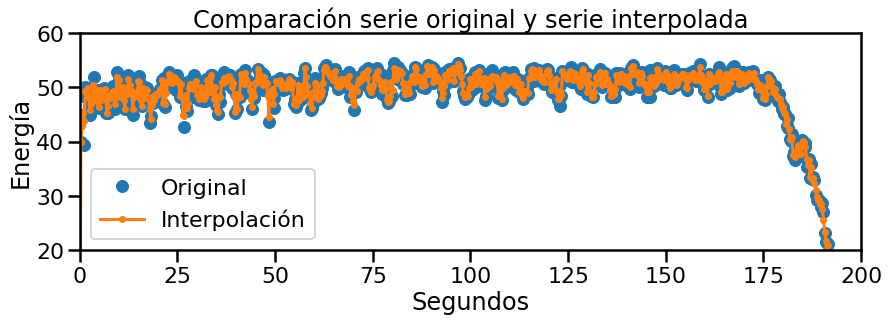

In [37]:
last = segments['start'].values[-1]
# utilizamos el doble de puntos que la serie original
n = len(segments)

timbre = np.vstack(segments['timbre']).T
interp = interp1d(segments['start'].values, timbre)
timbre_interpolado = interp(np.linspace(0,last,n)).T

plt.figure(figsize=(14,4))
plt.plot(segments['start'],timbre.T[:,0],'o',label='Original')
plt.plot(np.linspace(0,last,n),timbre_interpolado[:,0],'.-', label='Interpolación')
plt.xlabel('Segundos')
plt.ylabel('Energía')
plt.xlim(0,200)
plt.ylim(20,60)
plt.legend()
plt.title('Comparación serie original y serie interpolada');

Dependiendo de la canción, los datos de timbre, pitch o combinados pueden tener la información para separar la canción en partes. En algunos casos podría ser útil hacer transformaciones a los datos y normalizarlos. En este caso usamos los datos de timbre como vienen.

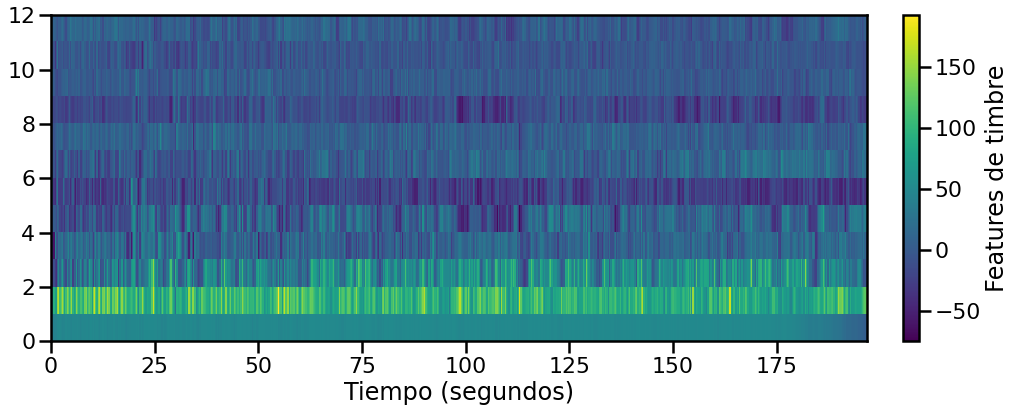

In [38]:
X = np.vstack(segments['timbre']).T

interp = interp1d(segments['start'].values, X)
t = np.linspace(0,last,n)
X_interpolado = interp(t).T

plt.subplots(figsize=(16,6))
plt.imshow(X_interpolado.T, aspect='auto',origin='bottom',extent=[0,last,0,12], interpolation='none');
plt.colorbar(label='Features de timbre',fraction=0.046, pad=0.04)
plt.xlabel('Tiempo (segundos)');

Visualicemos utilizando TSNE los datos de timbre y las partes de la canción

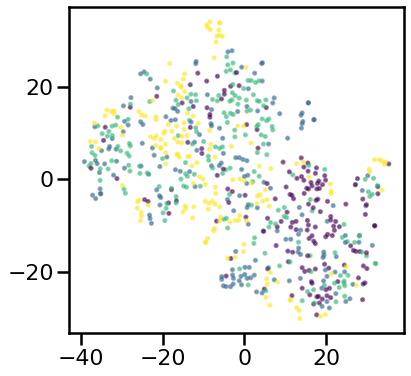

In [39]:
Z = TSNE(n_components=2).fit_transform(X_interpolado)

# arreglo de numeros con las partes para colorear
sr = (n-1)/last
partes = np.zeros(X_interpolado.shape[0])
for i,part in enumerate([A,B,C,D]):
  for start, end in part:    
    partes[int(sr*start):int(sr*end)]=i

plt.subplots(figsize=(6,6))
plt.scatter(Z[:,0],Z[:,1],c=partes,alpha=0.5,s=10);

No resulta claro en este *track* cómo el timbre separa según las partes. Podemos mejorar esto agregandole un sentido temporal al análisis con las matrices de recurrencias.

Para construir la matriz de recurrencias calculamos las distancia coseno entre todos los pares de vectores para cada tiempo con la función _pdist_ 

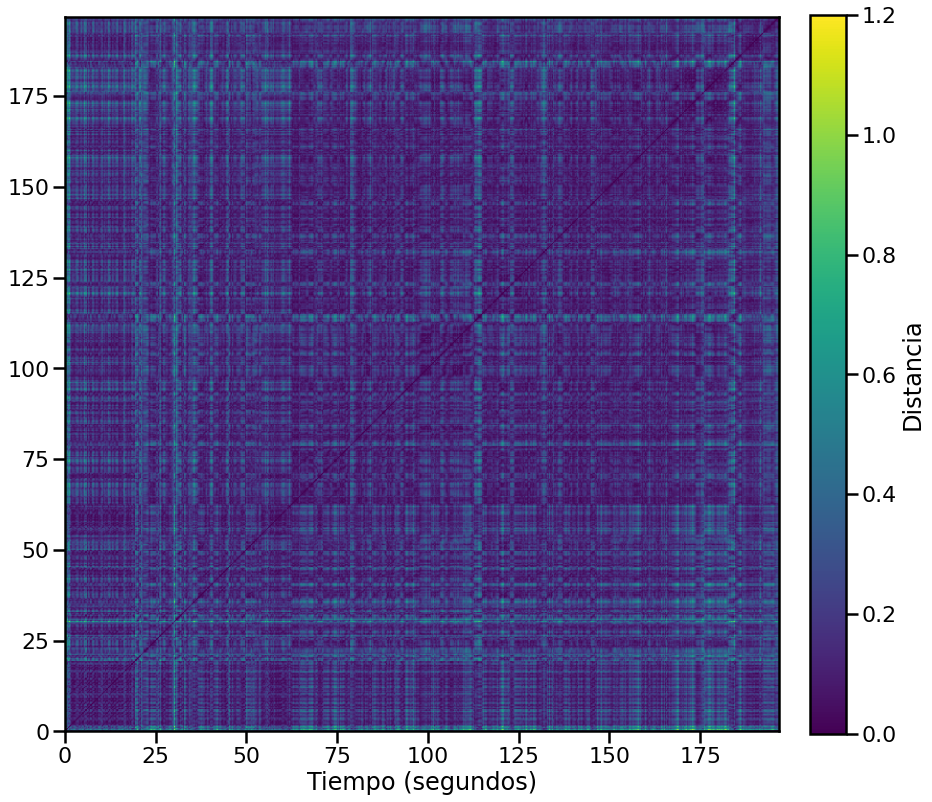

In [63]:
recurrencia_coseno = squareform(pdist(X_interpolado, metric='cosine'))

plt.figure(figsize=(14,14))
plt.imshow(recurrencia_coseno,aspect='auto',origin='bottom',extent=[0,last,0,last],vmax=1.2);
plt.colorbar(label='Distancia',fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.xlabel('Tiempo (segundos)');

Siguiendo la diagonal, observamos claramente dos "cuadrados" de las secciones instrumentales en tonos azul oscuro (baja distancia) desde el inicio de la canción hasta el segundo 19, y entre los segundos 53 a 62. El resto las alternancias son más sutiles pero podemos observar la tercera estrofa entre los segundos 97 y 114. Además, tenemos una "línea" de tono verdoso (alta distancia) que coincide con el inicio del último estribillo. Por último, el final de la coda también está indicada con una "línea" verdosa en el segundo 175.

Una forma de mejorar esta representación es indicando cuantos vecinos (k) se quiere considerar y transformando los valores de distancias o disimilaridades a afinidad. El paquete librosa tiene una función especial para hacer eso.

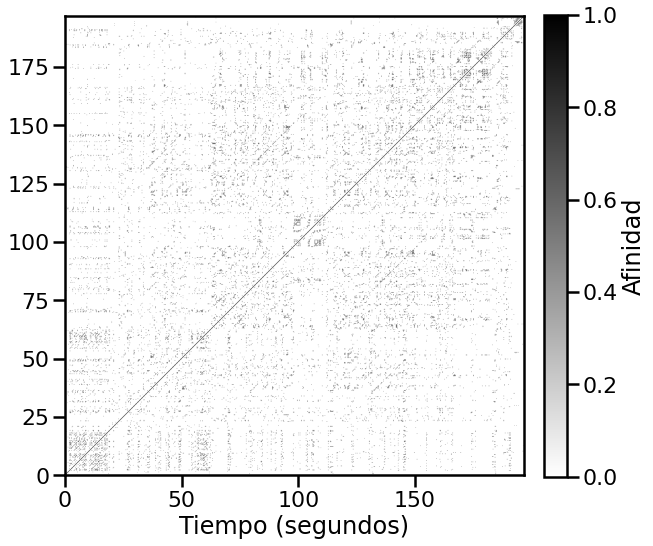

In [64]:
recurrencia_afinidad = librosa.segment.recurrence_matrix(X_interpolado.T,mode='affinity',sym=True, width=3, self=True)

plt.figure(figsize=(9,9))
plt.imshow(recurrencia_afinidad,aspect='auto',origin='bottom',extent=[0,last,0,last],cmap=plt.cm.gray_r);
plt.colorbar(label='Afinidad',fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.xlabel('Tiempo (segundos)');

La representación gráfica de afinidad muestra tres secciones en gris para los segmentos de segundos 0-19, 97-114 y 178. Solo la última sección se observa mejor en esta representación de afinidad, las demás ya fueron observadas y con más claridad en el gráfico de coseno.

Finalmente es posible suavizar esta representación para obtener algo más robusto. Librosa trae una función para hacer eso realzando las diagonales en el sentido temporal

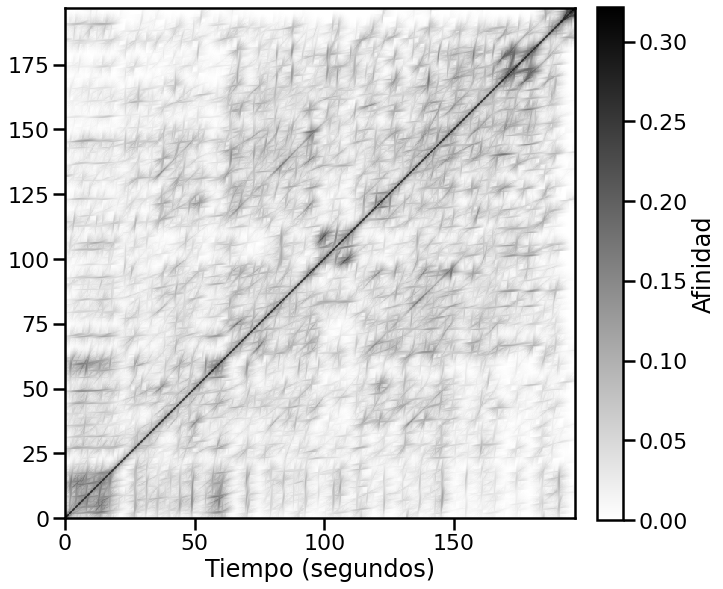

In [45]:
recurrencia_suave = librosa.segment.path_enhance(recurrencia_afinidad, 31, max_ratio=10.0, n_filters=12)

plt.figure(figsize=(10,10))
plt.imshow(recurrencia_suave,aspect='auto',origin='bottom',extent=[0,last,0,last],cmap=plt.cm.gray_r, interpolation='none');
plt.colorbar(label='Afinidad',fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.xlabel('Tiempo (segundos)');

Esta matriz suavizada le da de cierta forma coherencia temporal a las distancias. Es decir, si dos instantes de tiempo suenan parecido también sonaran parecido los instantes inmediatamente consecutivos.

Al forzar esto, es posible tratar de hacer algún tipo de clustering para reconocer las secciones que se repiten en el audio (estribillos, estrofas, etc). 

Este artículo [1] sugiere realizar clustering sobre los primeros autovectores de la matriz de recurrencia. En cierta medida es similar a cuando se hace PCA y se toman las primeras componentes. Esta técnica se conoce como clustering espectral (los matemáticos suelen hablar de espectro de autovalores, por eso el nombre)


[1] McFee, B., & Ellis, D. (2014). Analyzing Song Structure with Spectral Clustering. In ISMIR (pp. 405-410).

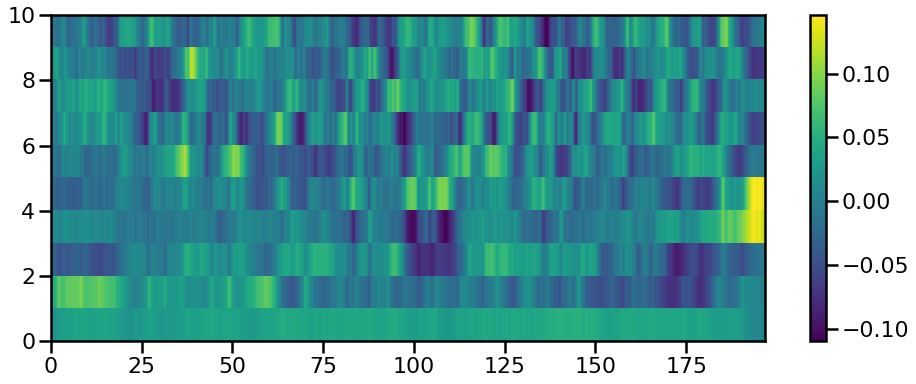

In [46]:
# Cálculo de autovectores de la matriz suavizada con la función eigh para matrices simétricas
autovalores, autovectores = np.linalg.eigh(recurrencia_suave)

# Los autovalores están ordenados de menor a mayor. Visualizamos los k últimos autovectores correspondientes a los autovalores más grandes
k = 10

plt.figure(figsize=(16,6))
plt.imshow(autovectores[:,-k:].T, aspect='auto', interpolation='none', extent=[0,last,0,k]);
plt.colorbar();

Tomamos los primeros k autovectores y visualizamos las secciones que encuentra sobre la matriz.




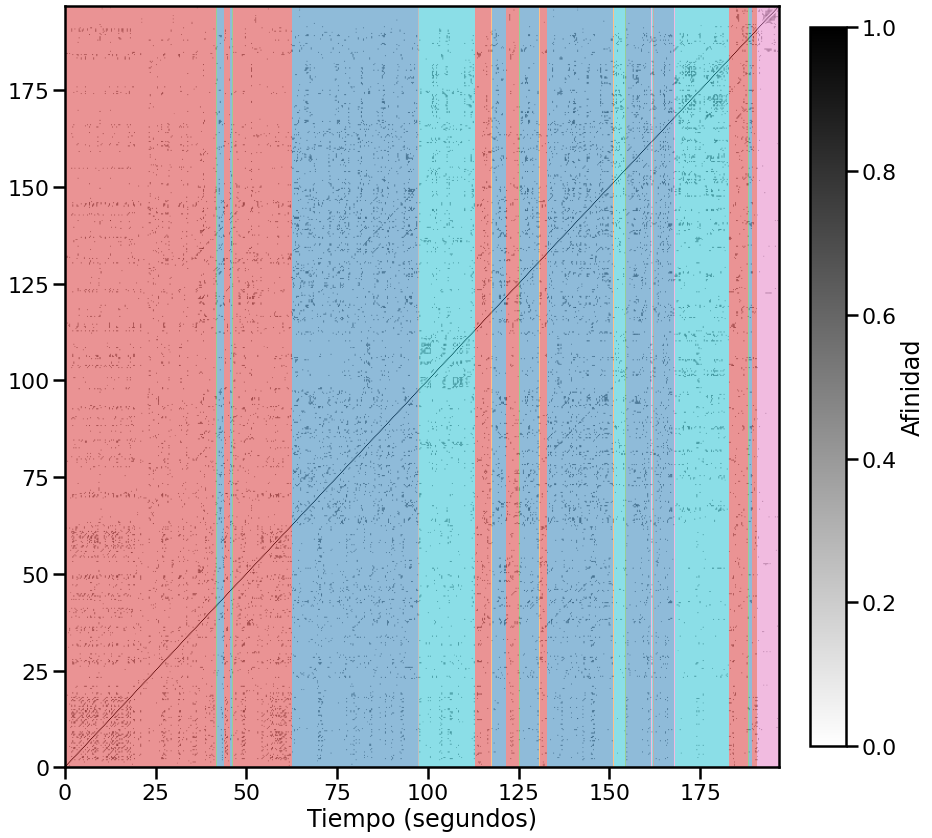

In [49]:
ss = StandardScaler()

clustering = KMeans(n_clusters=4,n_init=20)
clustering.fit(ss.fit_transform(autovectores[:,-k:]))

plt.figure(figsize=(14,14))
plt.imshow(recurrencia_afinidad, aspect='auto', origin='bottom', extent=[0,last,0,last], cmap=plt.cm.gray_r);
plt.colorbar(label='Afinidad',fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.xlabel('Tiempo (segundos)');

plt.imshow(clustering.labels_*np.ones(recurrencia_suave.shape),aspect='auto',cmap=plt.cm.tab10,alpha=0.5, extent=[0,last,0,last]);

La representación anterior indica un primer *cluster* desde el segundo 0 al 62, que coincidiría con la primera sección, más "tranquila", de la canción. No es capaz de distinguir las secciones instrumentales, de estrofa y estribillo que son evidentes al oyente humano.

Entre el segundo 62 al 97 se identifica el segundo *cluster* una sección más "enérgica", compuesta de la segunda estrofa y el último instrumental, y es seguido por un tercer *cluster* de estrofa "enérgica" entre los segundos 97 y 114. 

El resto de la canción tiene clusters superpuestos y no correspondidos con las secciones identificadas "de oído". Esto es coherente con la forma de la canción, climax creciente hasta el final, y que concluye con un *fade-away* hacia silencio, que sí se identifica en el cuarto *cluster*, diferente a los anteriores.

Chequeamos el resultado del clustering con el de la segmentación manual, y observamos un índice de Rand bastante bajo, solamente 0,08, consistente con el análisis que realizamos.


In [50]:
print('Rand index:', adjusted_rand_score(partes, clustering.labels_))

Rand index: 0.07989999355869368
